## 사전 훈련된 컨브넷 사용하기
* 작은 이미지 데이터셋에 딥러닝을 적용하는 일반적이고 매우 효과적인 방법은 사전 훈련된 네트워크를 사용하는 것입니다. 
* 원본 데이터셋이 충분히 크고 일반적이라면 사전 훈련된 네트워크에 의해 학습된 특성의 계층 구조는 실제 세상에 대한 일반적인 모델로 효율적인 역할을 할 수 있습니다. 
* 새로운 문제가 원래 작업과 완전히 다른 클래스에 대한 것이더라도 이런 특성은 많은 컴퓨터 비전 문제에 유용합니다. 
* 학습된 특성을 다른 문제에 적용할 수 있는 이런 유연성은 이전의 많은 얕은 학습 방법과 비교했을 때 딥러닝의 핵심 장점입니다. 이런 방식으로 작은 데이터셋을 가진 문제에도 딥러닝이 효율적으로 작동할 수 있습니다.
* 여기에서는 (1.4백만 개의 레이블된 이미지와 1,000개의 클래스로 이루어진) ImageNet 데이터셋에서 훈련된 대규모 컨브넷을 사용해 보겠습니다. ImageNet 데이터셋은 다양한 종의 강아지와 고양이를 포함해 많은 동물들을 포함하고 있습니다. 그래서 강아지 vs. 고양이 분류 문제에 좋은 성능을 낼 것 같습니다.
* 캐런 시몬연과 앤드류 지서먼이 2014년에 개발한 VGG16 구조를 사용하겠습니다. VGG16은 간단하고 ImageNet 데이터셋에 널리 사용되는 컨브넷 구조입니다. VGG16은 조금 오래되었고 최고 수준의 성능에는 못미치며 최근의 다른 모델보다는 조금 무겁습니다. 하지만 이 모델의 구조가 이전에 보았던 것과 비슷해서 새로운 개념을 도입하지 않고 이해하기 쉽기 때문에 선택했습니다. 
* VGG, ResNet, Inception, Inception-ResNet, Xception 등을 적용 할 수 있습니다.

### 사전 훈련된 네트워크를 사용하는 두 가지 방법
* **특성 추출** : 특성 추출기로 사전 훈련된 모델 이용
* 미세 조정 (Fine Tuning) : 사전훈련된 모델의 미세 튜닝

### 특성 추출

특성 추출은 사전에 학습된 네트워크의 표현을 사용해 새로운 샘플에서 흥미로운 특성을 뽑아내는 것입니다. 이런 특성을 사용하여 새로운 분류기를 처음부터 훈련합니다.

앞서 보았듯이 컨브넷은 이미지 분류를 위해 두 부분으로 구성됩니다. 먼저 연속된 합성곱과 풀링 층으로 시작해서 완전 연결 분류기로 끝납니다. 첫 번째 부분을 모델의 **합성곱 기반층(convolutional base)**이라고 부르겠습니다. 컨브넷의 경우 특성 추출은 사전에 훈련된 네트워크의 합성곱 기반층을 선택해 새로운 데이터를 통과시키고 그 출력으로 새로운 분류기를 훈련합니다.

In [0]:
test = 1

%matplotlib inline

In [0]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [6]:
IMG_DIM = (150, 150)

train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
# train_labels = [fn.split('/')[1].split('.')[0].strip() for fn in train_files] # for linux
train_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in train_files] # for windows

validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
# validation_labels = [fn.split('/')[1].split('.')[0].strip() for fn in validation_files] # for linux
validation_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in validation_files] # for windows

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (1000, 150, 150, 3)


In [0]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

In [8]:
batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
# encode wine type labels
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[0:5], train_labels_enc[0:5])

['dog', 'dog', 'dog', 'dog', 'dog'] [1 1 1 1 1]


ImageNet 데이터셋에 훈련된 VGG16 네트워크의 합성곱 기반층을 사용하여 강아지와 고양이 이미지에서 유용한 특성을 추출해 보겠습니다. 그런 다음 이 특성으로 강아지 vs. 고양이 분류기를 훈련합니다.

VGG16 모델은 케라스에 패키지로 포함되어 있습니다. `keras.applications` 모듈에서 임포트할 수 있습니다. `keras.applications` 모듈에서 사용 가능한 이미지 분류 모델은 다음과 같습니다(모두 ImageNet 데이터셋에서 훈련되었습니다):

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

In [10]:
if test:
    from tensorflow.keras.applications import ____
    from tensorflow.keras.models import Model
    import tensorflow.keras

    vgg_base = ......


    vgg_base.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128

In [11]:
if test:
    import pandas as pd
    pd.set_option('max_colwidth', -1)

    layers = [  ...............  ]
    pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f57fa50b358>,input_1,True
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f57f41cf2b0>,block1_conv1,True
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f57f41cfa20>,block1_conv2,True
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f57f41b5160>,block1_pool,True
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f57f41b5198>,block2_conv1,True
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f57f413fc88>,block2_conv2,True
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f57f4151358>,block2_pool,True
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f57f4151390>,block3_conv1,True
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f57f415deb8>,block3_conv2,True
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f57f416f550>,block3_conv3,True


In [12]:
if test:
    print("Trainable layers:", vgg_base.______)

Trainable layers: [<tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32>, <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32>, <tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32>, <tf.Variable 'block1_conv2/bias:0' shape=(64,) dtype=float32>, <tf.Variable 'block2_conv1/kernel:0' shape=(3, 3, 64, 128) dtype=float32>, <tf.Variable 'block2_conv1/bias:0' shape=(128,) dtype=float32>, <tf.Variable 'block2_conv2/kernel:0' shape=(3, 3, 128, 128) dtype=float32>, <tf.Variable 'block2_conv2/bias:0' shape=(128,) dtype=float32>, <tf.Variable 'block3_conv1/kernel:0' shape=(3, 3, 128, 256) dtype=float32>, <tf.Variable 'block3_conv1/bias:0' shape=(256,) dtype=float32>, <tf.Variable 'block3_conv2/kernel:0' shape=(3, 3, 256, 256) dtype=float32>, <tf.Variable 'block3_conv2/bias:0' shape=(256,) dtype=float32>, <tf.Variable 'block3_conv3/kernel:0' shape=(3, 3, 256, 256) dtype=float32>, <tf.Variable 'block3_conv3/bias:0' shape=(256,) dtype=float32>, <tf.Varia

In [9]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
import tensorflow.keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = ..........
output = ...........

vgg_model = ..........
vgg_model.trainable = False

for layer in vgg_model.layers:
    layer.trainable = ......

vgg_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128

In [10]:
import pandas as pd
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fb8cb368ba8>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb887ed1a20>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb887c651d0>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb88740a908>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb88740a940>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb8874284a8>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb8873b7b00>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb8873c5f60>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb8873bd6a0>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb8873d7cf8>,block3_conv3,False


In [10]:
print("Trainable layers:", vgg_model.__________ )

Trainable layers: []


(1, 4, 4, 512)


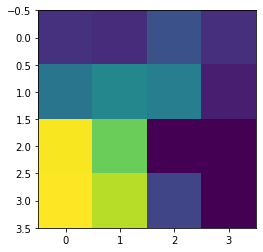

In [11]:
bottleneck_feature_example = vgg.______(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [ ]:
bottleneck_feature_example = vgg_model.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)

### 전이 모델을 위한 특성 추출
* 미리 학습된 VGG16 모델로부터 특성을 추출함
* 최종 특성 맵의 크기는 (4, 4, 512)입니다. 이 특성 위에 완전 연결 층을 놓을 것입니다

In [0]:
def get_bottleneck_features(model, input_imgs):    
    features = model.predict(input_imgs, verbose=1)
    return features

In [12]:
train_features_vgg = get_bottleneck_features(_______, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(_______, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

1000/1000 [==============================] - 3s 3ms/sample
Train Bottleneck Features: (3000, 8192) 	Validation Bottleneck Features: (1000, 8192)


In [14]:
if test:
    print(train_features_vgg[0][:5])
    print(validation_features_vgg[0][:5])

[0.1867754  0.         0.         0.14237325 0.        ]
[0.         0.         0.         0.         0.47230554]


## Base ConvNet 특성 위에 완전 연결 층을 놓는 두 가지 방식
1. 새로운 데이터셋에서 합성곱 기반층을 실행하고 출력을 넘파이 배열로 디스크에 저장합니다. 그다음 이 데이터를 독립된 완전 연결 분류기에 입력으로 사용합니다. 합성곱 연산은 전체 과정 중에서 가장 비싼 부분입니다. 이 방식은 모든 입력 이미지에 대해 합성곱 기반층을 한 번만 실행하면 되기 때문에 빠르고 비용이 적게 듭니다. 하지만 이런 이유 때문에 이 기법에는 데이터 증식을 사용할 수 없습니다.
2. 준비한 모델(conv_base) 위에 Dense 층을 쌓아 확장합니다. 그다음 입력 데이터에서 엔드 투 엔드로 전체 모델을 실행합니다. 모델에 노출된 모든 입력 이미지가 매번 합성곱 기반층을 통과하기 때문에 데이터 증식을 사용할 수 있습니다. 하지만 이런 이유로 이 방식은 첫 번째 방식보다 훨씬 비용이 많이 듭니다.

### 완전 연결층 방식1 - 전이 모델 설계  
* 완전 연결 분류기를 정의함 (규제를 위해 드롭아웃을 사용합니다)

In [13]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

input_shape = vgg_model.output_shape[1]  # 8192

model = .....
.............



model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________


### 완전 연결층 방식1 - 전이 모델 학습
* 저장된 데이터와 레이블을 사용해 훈련합니다

In [14]:
history = model.____(x=_______, y=_________,
                    validation_data=(_______, ________),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 1s 289us/sample - loss: 0.4294 - acc: 0.7963 - val_loss: 0.4017 - val_acc: 0.8150
Epoch 2/30
3000/3000 [==============================] - 1s 210us/sample - loss: 0.2896 - acc: 0.8717 - val_loss: 0.2869 - val_acc: 0.8750
Epoch 3/30
3000/3000 [==============================] - 1s 202us/sample - loss: 0.2374 - acc: 0.8997 - val_loss: 0.2702 - val_acc: 0.8820
Epoch 4/30
3000/3000 [==============================] - 1s 225us/sample - loss: 0.2035 - acc: 0.9177 - val_loss: 0.2662 - val_acc: 0.9000
Epoch 5/30
3000/3000 [==============================] - 1s 218us/sample - loss: 0.1705 - acc: 0.9287 - val_loss: 0.2804 - val_acc: 0.8950
Epoch 6/30
3000/3000 [==============================] - 1s 224us/sample - loss: 0.1348 - acc: 0.9460 - val_loss: 0.2859 - val_acc: 0.8990
Epoch 7/30
3000/3000 [==============================] - 1s 211us/sample - loss: 0.1207 - acc: 0.9520 - val_loss: 0.2892 - va

* 훈련 손실과 정확도 곡선을 살펴보자

In [0]:
model.save('cats_dogs_tlearn_basic_cnn.h5')
!mv 'cats_dogs_tlearn_basic_cnn.h5' '/content/drive/My Drive/cnn-model'

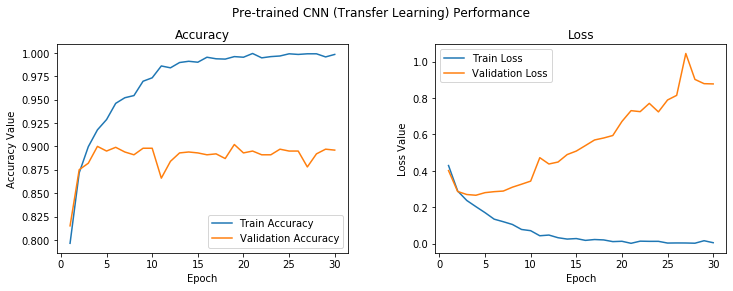

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

### 완전 연결층 방식2 - 데이터 증식 적용 전이 모델 
* 준비한 모델(conv_base) 위에 Dense 층을 쌓아 확장합니다. 그다음 입력 데이터에서 엔드 투 엔드로 전체 모델을 실행합니다. 모델에 노출된 모든 입력 이미지가 매번 합성곱 기반층을 통과하기 때문에 데이터 증식을 사용할 수 있습니다. 하지만 이런 이유로 이 방식은 첫 번째 방식보다 훨씬 비용이 많이 듭니다.
* 이 방법은 훨씬 느리고 비용이 많이 들지만 훈련하는 동안 데이터 증식 기법을 사용할 수 있습니다. `conv_base` 모델을 확장하고 입력 데이터를 사용해 엔드 투 엔드로 실행합니다.
* 이 기법은 연산 비용이 크기 때문에 GPU를 사용할 수 있을 때 시도해야 합니다. CPU에서는 적용하기 매우 힘듭니다. GPU를 사용할 수 없다면 첫 번째 방법을 사용하세요.
* 모델은 층과 동일하게 작동하므로 층을 추가하듯이 `Sequential` 모델에 (`conv_base` 같은) 다른 모델을 추가할 수 있습니다:

데이터 증식 하기

In [0]:
train_datagen = _________(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = __________(rescale=1./255)

train_generator = __________(train_imgs, train_labels_enc, batch_size=30)
val_generator = __________(validation_imgs, validation_labels_enc, batch_size=20)

In [18]:
print(train_imgs.shape, validation_imgs.shape)

(3000, 150, 150, 3) (1000, 150, 150, 3)


### 완전 연결층 방식2 - 데이터 증식 전이 모델 설계  

In [19]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

.....
.....
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 8192)              14714688  
_________________________________________________________________
dense_3 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 19,172,673
Trainable params: 4,457,985
Non-trainable params: 14,714,688
__________________________________

### 완전 연결층 방식2 - 데이터 증식 전이 모델 학습

In [20]:
history = model._________(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, verbose=1)

Epoch 1/100
100/100 [==============================] - 23s 234ms/step - loss: 0.6613 - acc: 0.5960 - val_loss: 0.5250 - val_acc: 0.7780
Epoch 2/100
100/100 [==============================] - 18s 184ms/step - loss: 0.5693 - acc: 0.6933 - val_loss: 0.4360 - val_acc: 0.8160
Epoch 3/100
100/100 [==============================] - 19s 192ms/step - loss: 0.5275 - acc: 0.7380 - val_loss: 0.3789 - val_acc: 0.8460
Epoch 4/100
100/100 [==============================] - 19s 190ms/step - loss: 0.4922 - acc: 0.7580 - val_loss: 0.3476 - val_acc: 0.8520
Epoch 5/100
100/100 [==============================] - 19s 193ms/step - loss: 0.4461 - acc: 0.7987 - val_loss: 0.3273 - val_acc: 0.8530
Epoch 6/100
100/100 [==============================] - 19s 192ms/step - loss: 0.4507 - acc: 0.7877 - val_loss: 0.3137 - val_acc: 0.8630
Epoch 7/100
100/100 [==============================] - 19s 192ms/step - loss: 0.4343 - acc: 0.7963 - val_loss: 0.3023 - val_acc: 0.8720
Epoch 8/100
100/100 [===========================

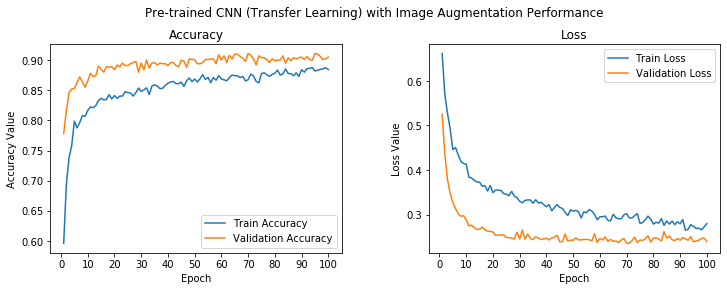

In [24]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) with Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
model.save('cats_dogs_tlearn_img_aug_cnn.h5')